In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter, Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis
from itertools import combinations

In [3]:
os.environ['GAMMAPY_DATA'] = '/home/rishank/gammapy-datasets/'
!echo $GAMMAPY_DATA
!ls $GAMMAPY_DATA

/home/rishank/gammapy-datasets/
catalogs	     ebl	    figures	  images
cta-1dc		     fermi_3fhl     gamma-cat	  joint-crab
dark_matter_spectra  fermi-3fhl-gc  hess-dl3-dr1  tests


In [4]:
model_simu = PowerLawSpectralModel(
    amplitude=1.289e-12 / u.cm ** 2 / u.s / u.TeV,
    reference=1 * u.TeV,
    index=2.22,
)

model = SkyModel(spectral_model=model_simu)
print(model)

SkyModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True


In [5]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [6]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [7]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [8]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [9]:
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 37086 
    Total predicted counts          : 37100.14
    Total off counts                : 100871.00

    Total background counts         : 20174.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.95

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:
dataset_onoff.models = model
fit = Fit([dataset_onoff])

In [12]:
minuit_opts = {"tol": 0.001, "strategy": 1}
result_minuit = fit.run(optimize_opts=minuit_opts)
print(result_minuit)
result_minuit.parameters.to_table()

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 35
	total stat : 8.89



name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
index,2.214e+00,6.646e-03,,nan,nan,False
amplitude,1.286e-12,1.406e-14,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


In [13]:
def evaluate_err(self, minu, energy, epsilon=1e-4):

        p_cov = minu.parameters.covariance
        eps = np.sqrt(np.diag(minu.parameters.covariance)) * epsilon

        df_dp = self._evaluate_gradient(energy, eps)
        f_cov = df_dp.T @ p_cov @ df_dp
        f_err = np.sqrt(np.diagonal(f_cov))

        q = self(energy)
        return u.Quantity([q.value, f_err], unit=q.unit)

In [14]:
def plot_error(
        self,
        energy_range,
        ax=None,
        energy_unit="TeV",
        flux_unit="cm-2 s-1 TeV-1",
        energy_power=0,
        n_points=100,
        **kwargs,
    ):
        
        ax = plt.gca() if ax is None else ax

        kwargs.setdefault("facecolor", "black")
        kwargs.setdefault("alpha", 0.2)
        kwargs.setdefault("linewidth", 0)

        emin, emax = energy_range
        energy = MapAxis.from_energy_bounds(emin, emax, n_points, energy_unit).edges

        flux, flux_err = evaluate_err(self,result_minuit,energy).to(flux_unit)

        y_lo = self._plot_scale_flux(energy, flux - flux_err, energy_power)
        y_hi = self._plot_scale_flux(energy, flux + flux_err, energy_power)

        where = (energy >= energy_range[0]) & (energy <= energy_range[1])
        ax.fill_between(energy.value, y_lo.value, y_hi.value, where=where, **kwargs)

        self._plot_format_ax(ax, energy, y_lo, energy_power)
        return ax

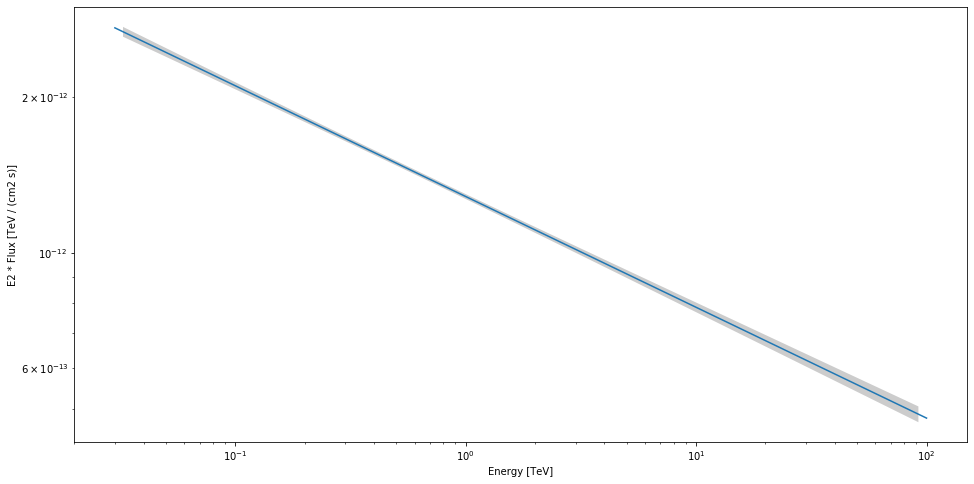

In [15]:
energy_range = [0.03, 100] * u.TeV
plt.figure(figsize=[16,8])
model_simu.plot(energy_range=energy_range, energy_power=2)
ax = plot_error(self=model_simu,energy_range=energy_range, energy_power=2)

In [16]:
profile = fit.stat_profile(parameter="index")

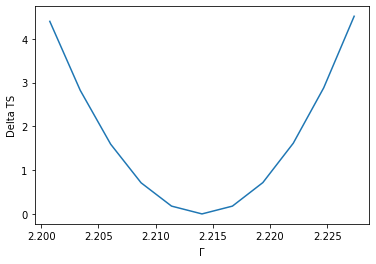

In [17]:
total_stat = result_minuit.total_stat
plt.plot(profile["values"], profile["stat"] - total_stat)
plt.xlabel(r"$\Gamma$")
plt.ylabel("Delta TS");

In [18]:
def make_contours(fit, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(["index", "amplitude"], r=2):
            contour = fit.minos_contour(
                result.parameters[par_1],
                result.parameters[par_2],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{par_1}_{par_2}"] = {
                par_1: contour["x"].tolist(),
                par_2: contour["y"].tolist(),
            }
        cts_sigma.append(contours)
    return cts_sigma

In [19]:
sigma = [1, 2]
cts_sigma = make_contours(fit, result_minuit, 10, sigma)

In [20]:
pars = {
    "phi": r"$phi_0 / (10^{-11} {TeV}^{-1} {cm}^{-2} {s}^{-1})$",
    #"phi": r"$\phi_0 \,/\,(10^{-11}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
    "index": r"$index$",
}

panels = [
    {
        "x": "index",
        "y": "phi",
        "cx": (lambda ct: ct["contour_index_amplitude"]["index"]),
        "cy": (
            lambda ct: np.array(1e12)
            * ct["contour_index_amplitude"]["amplitude"]
        ),
    }
]

In [21]:
def plot_contour_line(ax, x, y, **kwargs):
    """Plot smooth curve from contour points"""
    from scipy.interpolate import CubicSpline

    # close countour
    xf = np.append(x, x[0])
    yf = np.append(y, y[0])

    # curve parametrization must be strictly increasing
    # so we use the cumulative distance of each point from the first one
    dist = np.sqrt(np.diff(xf) ** 2.0 + np.diff(yf) ** 2.0)
    dist = [0] + list(dist)
    t = np.cumsum(dist)
    ts = np.linspace(0, t[-1], 50)

    # 1D cubic spline interpolation
    cs = CubicSpline(t, np.c_[xf, yf], bc_type="periodic")
    out = cs(ts)

    # plot
    ax.plot(out[:, 0], out[:, 1], "-", **kwargs)
    ax.plot(xf, yf, "+", color=kwargs["color"])

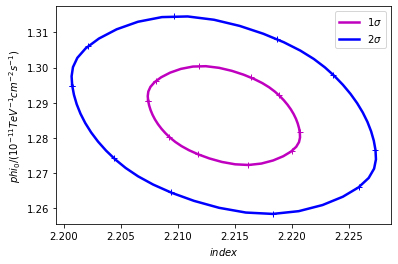

In [22]:
axes = plt.axes()
colors = ["m","b"]
xlabel = pars[panels[0]["x"]]
ylabel = pars[panels[0]["y"]]
for ks in range(len(cts_sigma)):
    plot_contour_line(
        axes,
        panels[0]["cx"](cts_sigma[ks]),
        panels[0]["cy"](cts_sigma[ks]),
        lw=2.5,
        color=colors[ks],
        label=f"{sigma[ks]}" + r"$\sigma$",
    )
axes.set_xlabel(xlabel)
axes.set_ylabel(ylabel)
plt.legend()
